#### Develop the formula for Fit-score
It must have following properties:
* larger value of the score indicates better groupings of users (users of similarities are grouped togehter)
* it promotes formation of a fewer set of user groups/communities

#### A promoted version of Fit-Score
$$
fs_1 = \sum_{j = 1}^{k} (\sum_{i \in U_{j}} \text{P-value}(u_i,D_j)_{i}) - C \cdot |\text{buffer}|
$$


* $u_i$: $i$th user
* $D_j$: the distance metrics learned for $j$th user group
* $U_j$: $j$th user group
* $|\cdot|$: size of users in the container
* $C$: the parameter determines the strength of penalty for more members in the buffer
* $N$: the total number of users in fit group, $\sum_{j = 1}^{k} |U_{j}|$

In [1]:
from git_fit_score_simp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Experiment Objective:
    * Factos Subjective to Test:
        a. the number of groups
        b. the size of populations
        c. goodness of fit of members to group
    * simulation data
        a. p-value score of each members to given group
        b. composition of groups

#### Experiment 01:   2-group population

In [2]:
# user defined function to generate simulation values

def drawGroup(true_group, error_prob, all_group_labels):
    """ Draw random group label from a complete set of all_group_label """
    import numpy as np
    
    is_error = np.random.sample() < error_prob
    
    if isinstance(all_group_labels, tuple):
        all_group_labels = all_group_labels[:]
    
    if is_error:
        other_group_labels = [label for label in all_group_labels if label != true_group]
        actual_label = np.random.choice(other_group_labels, 1)[0]
    else:
        actual_label = true_group
    
    return actual_label 


def genPval(true_group, actual_group, true_min_pval=0.8):
    """ Generate p-value based on the true_group and actual_group """
    import numpy as np
    
    is_diff = not true_group == actual_group
    if is_diff:
        pval = np.random.uniform(0, true_min_pval)
    else:
        pval = np.random.uniform(true_min_pval, 1)
    return pval


def genSimData(pop_size, group_prob, mis_classification_prob):
    """Generate simulation output form the learning algorithm"""
    
    if not sum(group_prob)==1:
        try:
            raise ValueError('HiThere')
        except ValueError:
            print("ERROR: group probabilities do not sum to 1!")

    true_num_group = len(group_prob)
    uniq_group_labels = range(true_num_group)

    # generate user basic information
    user_ids = range(pop_size)
    # , size=None, replace=True, p=None
    true_groups = np.random.choice(uniq_group_labels, size=pop_size, replace=True, p=group_prob)

    sim_result = pd.DataFrame({"user_id": user_ids, "true_group": true_groups})

    # generate conditioanl results
    sim_result["actual_group"] = [drawGroup(tg, mis_classification_prob, uniq_group_labels) \
                                  for tg in sim_result.true_group]
    sim_result["pval"] = sim_result[["true_group", "actual_group"]].apply(lambda x: genPval(x[0], x[1], 0.8), \
                                                                          axis=1)
    return sim_result


def simDataTransform(sim_data, buffer_size=0):
    """ re-structure simulated data.frame into tuple (pvalue-list, buffer-list)
    """
    pval_group = []
    for group_id in sim_data.actual_group.unique():
        pvalues = list(sim_data.ix[sim_data.actual_group == group_id, "pval"])
        pval_group.append(pvalues)

    # generate buffer, remove selected user from sim_data
    # and put them in buffers (user_id)
    buffers = []
    # method is not implemented 
    
    return (pval_group, buffers)


def statSummary(x):
    """Return a descriptive summary to describe the distribution """
    x_mean = np.mean(x)
    x_median = np.median(x)
    x_std = np.std(x)
    x_min, x_max = min(x), max(x)
    return (x_mean, x_median, x_std, x_min, x_max)


def expExectuor(param_grid, k_fold=100):
    """ Conduct simulation experiment based on given
        experiment configuraiton.
    """

    import time
    
    # input argument
    param_meshgrid_df = pd.DataFrame(list(param_grid))

    # calcualte job information
    total_iteration = param_meshgrid_df.shape[0]

    # output dataframe container
    exp_results = param_meshgrid_df.copy()
    # statistics container
    fs_mean, fs_median, fs_std, fs_min, fs_max = [], [], [], [], []
    exp_time_costs = []

    for i, param_row in param_meshgrid_df.iterrows():
        # load experiment parameter
        the_pop_size = param_row["pop_size"]
        the_group_prob = param_row["group_prob"]
        the_misclass_prob = param_row["misclass_prob"]

        print("{0}th (out of {1}) experiment is under conducting...".format(i, total_iteration))

        fit_scores = []
        start_time = time.time()
        for i_rep in range(k_fold):

            sim_result = genSimData(the_pop_size, the_group_prob, the_misclass_prob )
            transformed = simDataTransform(sim_result)
            the_fit_score = get_fit_score(transformed[0], transformed[1], c=1)
            fit_scores.append(the_fit_score)

        duration_time = (time.time() - start_time)
        print("Time cost: {0:.1f} seconds".format(duration_time))

        fs_mean.append(np.mean(fit_scores))
        fs_median.append(np.median(fit_scores))
        fs_std.append(np.std(fit_scores))
        fs_min.append(max(fit_scores))
        fs_max.append(min(fit_scores))

        exp_time_costs.append(duration_time)

    exp_results["pval_mean"] = fs_mean
    exp_results["pval_median"] = fs_median
    exp_results["pval_std"] = fs_std
    exp_results["pval_min"] = fs_min
    exp_results["pval_max"] = fs_max
    exp_results["time_cost"] = exp_time_costs
    return exp_results

In [3]:
import numpy as np
import pandas as pd

# set random seed
np.random.seed(123)

# generate user_id, true_group, label_group, p_val
pop_size = 100
group_prob = (0.5, 0.5)
error_prob = 0.1

In [4]:
#  simluation pipeline showcase
sim_result = genSimData(pop_size=100, group_prob=[0.5, 0.3, 0.2], mis_classification_prob=0.1)
transformed = simDataTransform(sim_result)
fit_score = get_fit_score(transformed[0], transformed[1], c=1)
print("fit score: {0:.2f}".format(fit_score))

fit score: 83.51


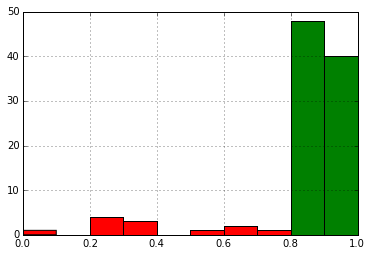

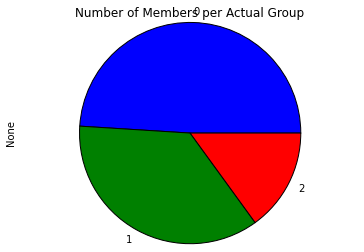

In [5]:
# validate the generated data
match_idx = sim_result[["true_group", "actual_group"]].apply(lambda x: x[0]==x[1], axis=1)
dismatch_idx = [not i for i in match_idx]

sim_result.ix[match_idx, "pval"].hist(range=[0, 1], facecolor="green")
sim_result.ix[dismatch_idx, "pval"].hist(range=[0, 1], facecolor="red")
plt.show()

sim_result.actual_group.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Number of Members per Actual Group')

In [6]:
# define the parameter meshgrid
from sklearn.grid_search import ParameterGrid

pop_size_range = [10**i for i in range(2, 7)]
group_prob_range = [(a, 1-a) for a in np.arange(0.5, 0.95, 0.05)]                
misclass_prob_range = list(np.arange(0.0, 0.50, 0.05))

param_ranges = {"pop_size": pop_size_range, "group_prob": group_prob_range, 
                "misclass_prob": misclass_prob_range}

param_meshgrid = ParameterGrid(param_ranges)

In [7]:
exp_results = expExectuor(param_meshgrid, k_fold=10)

0th (out of 450) experiment is under conducting...
Time cost: 0.1 seconds
1th (out of 450) experiment is under conducting...
Time cost: 0.4 seconds
2th (out of 450) experiment is under conducting...
Time cost: 4.2 seconds
3th (out of 450) experiment is under conducting...
Time cost: 42.4 seconds
4th (out of 450) experiment is under conducting...
Time cost: 417.6 seconds
5th (out of 450) experiment is under conducting...
Time cost: 0.1 seconds
6th (out of 450) experiment is under conducting...
Time cost: 0.4 seconds
7th (out of 450) experiment is under conducting...
Time cost: 4.3 seconds
8th (out of 450) experiment is under conducting...
Time cost: 42.5 seconds
9th (out of 450) experiment is under conducting...
Time cost: 415.9 seconds
10th (out of 450) experiment is under conducting...
Time cost: 0.1 seconds
11th (out of 450) experiment is under conducting...
Time cost: 0.4 seconds
12th (out of 450) experiment is under conducting...
Time cost: 4.2 seconds
13th (out of 450) experiment 

In [8]:
import datetime
dt = datetime.datetime.now().strftime('%Y%m%d_%H%M')
fname = "result_fit_score_simp_%s.csv" % dt
exp_results.to_csv(fname, sep=",", header=True, index=False)

In [9]:
exp_results["pop_size"].unique()

array([    100,    1000,   10000,  100000, 1000000])

In [28]:
exp_results["log_pval_mean"] = [np.math.log(pval_mean, 10) for pval_mean in list(exp_results["pval_mean"])]
exp_results["group_a_prob"] = [a for a, b in exp_results["group_prob"]]
#exp_results["log_p"]
exp_results["fs_mean"] = [x[0]*1.0/x[1] for i, x in exp_results[["pval_mean", "pop_size"]].iterrows()]

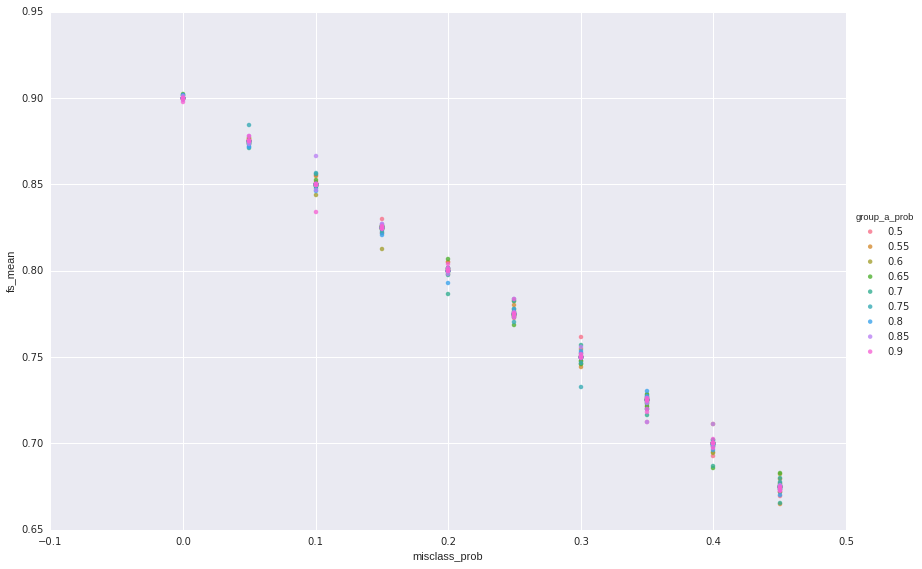

In [30]:
import seaborn as sns

# data_plot = exp_results[exp_results["pop_size"]==100]
data_plot = exp_results

sns.lmplot("misclass_prob", "fs_mean", data=data_plot, hue="group_a_prob", fit_reg=False, \
            scatter_kws={'alpha':0.8}, size=8, aspect=1.5)

In [31]:
exp_results["fs_mean"]

0      0.899861
1      0.899750
2      0.900078
3      0.900087
4      0.900015
5      0.875880
6      0.873836
7      0.875467
8      0.875133
9      0.874936
10     0.855271
11     0.851530
12     0.849761
13     0.849833
14     0.850037
15     0.829806
16     0.821666
17     0.825144
18     0.825017
19     0.824913
20     0.804919
21     0.800813
22     0.799575
23     0.800167
24     0.800028
25     0.772679
26     0.774401
27     0.775648
28     0.774368
29     0.774814
         ...   
420    0.803623
421    0.801463
422    0.800720
423    0.799960
424    0.800099
425    0.783867
426    0.775676
427    0.773353
428    0.774935
429    0.775088
430    0.749540
431    0.752038
432    0.750280
433    0.750038
434    0.750057
435    0.718018
436    0.720102
437    0.726291
438    0.724613
439    0.725054
440    0.702548
441    0.697540
442    0.700309
443    0.700390
444    0.700118
445    0.672262
446    0.672884
447    0.673943
448    0.674698
449    0.675038
Name: fs_mean, dtype: fl